# Top Mass DCTR 1D - $m_{jjj}$

This notebook attempts to train and validate a DCTR model that reweights __only__ $m_T = 172.5 \rightarrow 175.0$ using only reconstructed hadronic mass $m_{jjj}$ for each event

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.

## Process Data

In [3]:
# Path to downloaded data from Zenodo
data_dir0 = 'DCTRFitting/'
data_dir1 = 'DCTRFitting/'

In [4]:
# fetch m_jjj vals from default dataset
train_dataset_0_mjjj = np.load(data_dir0 + 'part_172_5_6j_obs.npy')[:, :1]
train_dataset_0_mjjj_x4 = np.load(data_dir1 +
                                  'part_172_5_6j_obs_x4.npy')[:, :1]
# combine orignal and x4 samples
train_dataset_0_mjjj = np.concatenate(
    (train_dataset_0_mjjj, train_dataset_0_mjjj_x4))

print(np.shape(train_dataset_0_mjjj))

# fetch m_jjj vals from varied dataset
train_dataset_1_mjjj = np.load(data_dir0 + 'part_175_0_6j_obs.npy')[:, :1]
train_dataset_1_mjjj_x4 = np.load(data_dir1 +
                                  'part_175_0_6j_obs_x4.npy')[:, :1]
# combine orignal and x4 samples
train_dataset_1_mjjj = np.concatenate(
    (train_dataset_1_mjjj,
     train_dataset_1_mjjj_x4))  #[:len(train_dataset_0_mjjj)]

print(np.shape(train_dataset_1_mjjj))

(287065, 1)
(294294, 1)


The model will see an unequal number of events from the uniformly sampled mass data and the fixed mass data. We will have to correct this with a liklihood ratio factor when reweighting.

In [5]:
X0 = train_dataset_0_mjjj
X1 = train_dataset_1_mjjj

print(len(X1)/len(X0)) # different sizes if != 1

1.0251824499677773


In [6]:
Y0 = np.zeros_like(X0[:,0])
Y1 = np.ones_like(X1[:,0])

In [7]:
X = np.concatenate((X0, X1), axis = 0)
X /= 100.

Y = np.concatenate((Y0, Y1), axis = 0)
Y = to_categorical(Y, num_classes=2)

In [8]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.2, shuffle=True)

In [9]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(465088, 1)
(465088, 2)
(116271, 1)
(116271, 2)


## Build Model

In [10]:
inputs = Input((1,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr = Model(inputs = inputs, outputs = outputs)
dctr.compile(loss='categorical_crossentropy', optimizer='Adam')

## Train model

Model has a tendency to initialize at trivial minima of the loss function (loss ~ 8 or loss ~7); the mode's outputs are all [1, 0] or all [0, 1] respecively in these cases. We do 100 iterations of initializations to explore the fraction of initiziations that succeed in being able to train a non-trivial model(loss after first epoch ~1), and keep the weights from such a model to complete the rest of training.

In [11]:
n_fail1 = 0
n_fail2 = 0
n_succ = 0
iterations = 10

dctr_weights = 0

for i in range(iterations):
    print("Iteration: ", i)

    K.clear_session()
    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

    outputs = Dense(2, activation='softmax')(hidden_layer_3)

    dctr = Model(inputs=inputs, outputs=outputs)
    dctr.compile(loss='categorical_crossentropy',
                 optimizer='Adam',
                 metrics=['accuracy'])

    history = dctr.fit(X_train,
                       Y_train,
                       epochs=1,
                       batch_size=1000,
                       validation_data=(X_val, Y_val),
                       verbose=2)
    if history.history['val_loss'][0] > 8:
        # Fail case 1, model output [1, 0] for all preds
        n_fail1 += 1
        print("Fail (case 1)")
        pass
    elif history.history['val_loss'][0] > 7:
        # Fail case 2, , model output [0, 1] for all preds
        n_fail2 += 1
        print("Fail (case 2)")
        pass
    else:  
        # success
        n_succ += 1
        print("Success")
        # remember successful weights
        dctr_weights = dctr.get_weights()
        pass


n_fail = n_fail1 + n_fail2

Iteration:  0
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 4s - loss: 0.6933 - acc: 0.5027 - val_loss: 0.6931 - val_acc: 0.5061
Success
Iteration:  1
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 3s - loss: 0.6931 - acc: 0.5044 - val_loss: 0.6930 - val_acc: 0.5061
Success
Iteration:  2
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 3s - loss: 0.6932 - acc: 0.5049 - val_loss: 0.6931 - val_acc: 0.5061
Success
Iteration:  3
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 3s - loss: 0.6934 - acc: 0.5030 - val_loss: 0.6932 - val_acc: 0.4944
Success
Iteration:  4
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 3s - loss: 0.6933 - acc: 0.5037 - val_loss: 0.6931 - val_acc: 0.5062
Success
Iteration:  5
Train on 465088 samples, validate on 116271 samples
Epoch 1/1
 - 3s - loss: 0.6931 - acc: 0.5041 - val_loss: 0.6931 - val_acc: 0.5170
Success
Iteration:  6
Train on 465088 samples, validate on 116271 sample

In [12]:
print("Number of initializations failed: ", n_fail, "/", iterations)
print("Percentage of initializations failed:", (100*n_fail/iterations), "%")

print("Number of initializations succeeded: ", n_succ, "/", iterations)
print("Percentage of initializations succeeded:", (100*n_succ/iterations), "%")

Number of initializations failed:  0 / 10
Percentage of initializations failed: 0.0 %
Number of initializations succeeded:  10 / 10
Percentage of initializations succeeded: 100.0 %


### Finish training

In [13]:
earlystopping = EarlyStopping(patience=10, restore_best_weights=True)


try:
    dctr.set_weights(dctr_weights)
    history = dctr.fit(X_train,
                   Y_train,
                   epochs=200,
                   batch_size=1000,
                   validation_data=(X_val, Y_val),
                   callbacks=[earlystopping],
                   verbose=1)
except:
    print(
        "Model did not have any successful initializations, will not continue training."
    )

Train on 465088 samples, validate on 116271 samples
Epoch 1/200
465088/465088 [==============================] - 3s 6us/step - loss: 0.6930 - acc: 0.5062 - val_loss: 0.6931 - val_acc: 0.5061
Epoch 2/200
465088/465088 [==============================] - 3s 6us/step - loss: 0.6931 - acc: 0.5056 - val_loss: 0.6930 - val_acc: 0.5061
Epoch 3/200
465088/465088 [==============================] - 3s 6us/step - loss: 0.6930 - acc: 0.5065 - val_loss: 0.6931 - val_acc: 0.5061
Epoch 4/200
465088/465088 [==============================] - 3s 6us/step - loss: 0.6930 - acc: 0.5068 - val_loss: 0.6930 - val_acc: 0.5069
Epoch 5/200
465088/465088 [==============================] - 3s 6us/step - loss: 0.6930 - acc: 0.5062 - val_loss: 0.6930 - val_acc: 0.5076
Epoch 6/200
465088/465088 [==============================] - 3s 6us/step - loss: 0.6930 - acc: 0.5082 - val_loss: 0.6930 - val_acc: 0.5083
Epoch 7/200
465088/465088 [==============================] - 3s 6us/step - loss: 0.6929 - acc: 0.5090 - val_loss: 

# Plot History

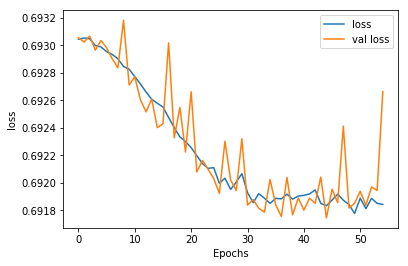

In [14]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

## Validation

### Load Datasets

In [15]:
test_dataset_0_mjjj = np.load(data_dir0 + 'part_172_5_6j_obs.npy')[:, :1]
test_dataset_1_mjjj = np.load(data_dir0 + 'part_175_0_6j_obs.npy')[:, :1]

print(np.shape(test_dataset_0_mjjj))
print(np.shape(test_dataset_1_mjjj))

(57710, 1)
(59119, 1)


In [16]:
# Define labels for legends
label_0 = r'$m_T=172.5$'

label_1 = r'$m_T=175.0$'

def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg._legend_box.align = "left"
    plt.tight_layout()

### Define reweighting function

We must calculate two liklihood ratios during reweighting: the first because the training datasets were different sizes, and the second because the validation datasets are different sizes.

In [17]:
# Get predicted probabilities
def reweight(default_dataset_172_5):

    data_input = default_dataset_172_5/100.

    f = dctr.predict(data_input)
    weights = f[:, 1] / f[:, 0]
    return weights

### Get weights

In [18]:
weights = reweight(default_dataset_172_5=test_dataset_0_mjjj)

### Analyze weights

In [19]:
print(max(weights))
print(max(1/weights))

1.3392526
1.1187704


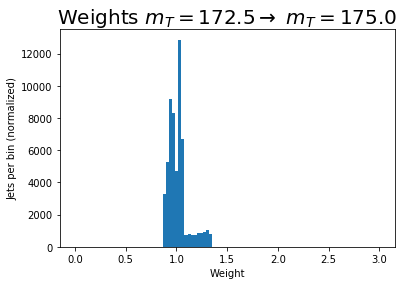

In [20]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_1, fontsize = 20)
#plt.savefig("Weights: Top Reweighting (fixed mass DCTR): m_{jjj} only.png")
plt.show()

### Validating Reweighting

In [21]:
# Define default plot styles
plot_style_0 = {'histtype':'step', 'color':'black', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'alpha':0.5, 'density':True}

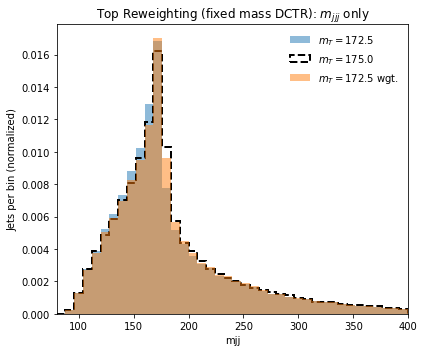

In [22]:
plt.figure(figsize=(6,5))
plt.title("Top Reweighting (fixed mass DCTR): $m_{jjj}$ only")
bins = np.linspace(80,400,41)
hist0 = plt.hist(test_dataset_0_mjjj, bins = bins, label = label_0, **plot_style_1)
hist1 = plt.hist(test_dataset_1_mjjj, bins = bins, label = label_1, **plot_style_0)
hist2 = plt.hist(test_dataset_0_mjjj, bins = bins, label = label_0 + ' wgt.', weights=weights, **plot_style_1)

plt.xlabel('mjj')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([80,400])
make_legend()
#plt.savefig("Top Reweighting (fixed mass DCTR): m_{jjj} only.png")
plt.show()

In [68]:
def reweight(d):
    f = dctr(d/100)
    weights = f[:, 1] / f[:, 0]
    return weights

### Fitting with data of mass 175 as unknown parameter

In [69]:
myinputs = Input(shape=(1,), dtype = tf.float32)

x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
#model.summary()
batch_size = 1000

def my_loss_wrapper(inputs,val=0.0):
    x = inputs
    weight = reweight(x)
    def my_loss(y_true,y_pred):
        print("y_true shape", y_true.shape)
        print("y_pred shape", y_pred.shape)
        t_loss = y_true*(y_true - y_pred)**2+(weight**2)*(1.-y_true)*(y_true - y_pred)**2
        return K.mean(t_loss)
    return my_loss

In [70]:
thetas = np.linspace(174,176,50)
lvals = []
for theta in thetas:
    model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,theta),metrics=['accuracy'])
    model.fit(np.array(X_train), np.argmax(Y_train,axis=1), epochs=10, batch_size=batch_size,validation_data=(np.array(X_val), np.argmax(Y_val,axis=1)),verbose=1)
    lvals+=[model.history.history['val_loss']]
    print
    pass
print(lvals) 

y_true shape (?, ?)
y_pred shape (?, 1)
Train on 465088 samples, validate on 116271 samples
Epoch 1/10
465088/465088 [==============================] - 10s 22us/step - loss: 0.2515 - acc: 0.5030 - val_loss: 0.2514 - val_acc: 0.4938
Epoch 2/10
465088/465088 [==============================] - 4s 9us/step - loss: 0.2515 - acc: 0.5032 - val_loss: 0.2514 - val_acc: 0.5100
Epoch 3/10
465088/465088 [==============================] - 5s 10us/step - loss: 0.2514 - acc: 0.5052 - val_loss: 0.2515 - val_acc: 0.5061
Epoch 4/10
465088/465088 [==============================] - 4s 9us/step - loss: 0.2514 - acc: 0.5056 - val_loss: 0.2513 - val_acc: 0.5139
Epoch 5/10
465088/465088 [==============================] - 5s 10us/step - loss: 0.2514 - acc: 0.5084 - val_loss: 0.2513 - val_acc: 0.5080
Epoch 6/10
465088/465088 [==============================] - 4s 10us/step - loss: 0.2513 - acc: 0.5087 - val_loss: 0.2513 - val_acc: 0.5079
Epoch 7/10
465088/465088 [==============================] - 5s 10us/step - 

Epoch 6/10
465088/465088 [==============================] - 5s 10us/step - loss: 0.2508 - acc: 0.5184 - val_loss: 0.2508 - val_acc: 0.5170
Epoch 7/10
465088/465088 [==============================] - 5s 10us/step - loss: 0.2508 - acc: 0.5190 - val_loss: 0.2510 - val_acc: 0.5131
Epoch 8/10
465088/465088 [==============================] - 5s 10us/step - loss: 0.2508 - acc: 0.5185 - val_loss: 0.2508 - val_acc: 0.5193
Epoch 9/10
465088/465088 [==============================] - 5s 10us/step - loss: 0.2508 - acc: 0.5182 - val_loss: 0.2508 - val_acc: 0.5191
Epoch 10/10
465088/465088 [==============================] - 5s 10us/step - loss: 0.2508 - acc: 0.5186 - val_loss: 0.2508 - val_acc: 0.5180
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 465088 samples, validate on 116271 samples
Epoch 1/10
465088/465088 [==============================] - 13s 28us/step - loss: 0.2508 - acc: 0.5186 - val_loss: 0.2508 - val_acc: 0.5191
Epoch 2/10
465088/465088 [==============================] - 5s 10us/step

465088/465088 [==============================] - 9s 19us/step - loss: 0.2508 - acc: 0.5190 - val_loss: 0.2509 - val_acc: 0.5162
Epoch 2/10
465088/465088 [==============================] - 3s 7us/step - loss: 0.2508 - acc: 0.5190 - val_loss: 0.2509 - val_acc: 0.5156
Epoch 3/10
465088/465088 [==============================] - 3s 7us/step - loss: 0.2508 - acc: 0.5190 - val_loss: 0.2509 - val_acc: 0.5172
Epoch 4/10
465088/465088 [==============================] - 3s 7us/step - loss: 0.2507 - acc: 0.5196 - val_loss: 0.2507 - val_acc: 0.5196
Epoch 5/10
465088/465088 [==============================] - 3s 7us/step - loss: 0.2508 - acc: 0.5193 - val_loss: 0.2508 - val_acc: 0.5192
Epoch 6/10
465088/465088 [==============================] - 3s 7us/step - loss: 0.2508 - acc: 0.5193 - val_loss: 0.2508 - val_acc: 0.5174
Epoch 7/10
465088/465088 [==============================] - 3s 7us/step - loss: 0.2508 - acc: 0.5188 - val_loss: 0.2508 - val_acc: 0.5193
Epoch 8/10
465088/465088 [==================

465088/465088 [==============================] - 3s 7us/step - loss: 0.2507 - acc: 0.5191 - val_loss: 0.2510 - val_acc: 0.5152
Epoch 8/10
465088/465088 [==============================] - 3s 8us/step - loss: 0.2508 - acc: 0.5188 - val_loss: 0.2508 - val_acc: 0.5186
Epoch 9/10
465088/465088 [==============================] - 3s 7us/step - loss: 0.2508 - acc: 0.5181 - val_loss: 0.2508 - val_acc: 0.5183
Epoch 10/10
465088/465088 [==============================] - 3s 8us/step - loss: 0.2508 - acc: 0.5187 - val_loss: 0.2508 - val_acc: 0.5178
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 465088 samples, validate on 116271 samples
Epoch 1/10
465088/465088 [==============================] - 9s 20us/step - loss: 0.2507 - acc: 0.5195 - val_loss: 0.2508 - val_acc: 0.5175
Epoch 2/10
465088/465088 [==============================] - 3s 7us/step - loss: 0.2508 - acc: 0.5187 - val_loss: 0.2508 - val_acc: 0.5192
Epoch 3/10
465088/465088 [==============================] - 3s 7us/step - loss: 0.2507 - 

465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5190 - val_loss: 0.2508 - val_acc: 0.5189
Epoch 3/10
465088/465088 [==============================] - 5s 10us/step - loss: 0.2508 - acc: 0.5194 - val_loss: 0.2507 - val_acc: 0.5194
Epoch 4/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2508 - acc: 0.5189 - val_loss: 0.2508 - val_acc: 0.5184
Epoch 5/10
465088/465088 [==============================] - 5s 10us/step - loss: 0.2507 - acc: 0.5194 - val_loss: 0.2507 - val_acc: 0.5181
Epoch 6/10
465088/465088 [==============================] - 5s 10us/step - loss: 0.2507 - acc: 0.5188 - val_loss: 0.2508 - val_acc: 0.5177
Epoch 7/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2508 - acc: 0.5188 - val_loss: 0.2507 - val_acc: 0.5194
Epoch 8/10
465088/465088 [==============================] - 5s 10us/step - loss: 0.2507 - acc: 0.5189 - val_loss: 0.2507 - val_acc: 0.5182
Epoch 9/10
465088/465088 [============

465088/465088 [==============================] - 5s 11us/step - loss: 0.2508 - acc: 0.5183 - val_loss: 0.2508 - val_acc: 0.5187
Epoch 8/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5194 - val_loss: 0.2508 - val_acc: 0.5167
Epoch 9/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5189 - val_loss: 0.2508 - val_acc: 0.5180
Epoch 10/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5190 - val_loss: 0.2508 - val_acc: 0.5194
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 465088 samples, validate on 116271 samples
Epoch 1/10
465088/465088 [==============================] - 15s 32us/step - loss: 0.2508 - acc: 0.5190 - val_loss: 0.2507 - val_acc: 0.5180
Epoch 2/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5188 - val_loss: 0.2507 - val_acc: 0.5193
Epoch 3/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.

Epoch 2/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5192 - val_loss: 0.2508 - val_acc: 0.5176
Epoch 3/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5192 - val_loss: 0.2508 - val_acc: 0.5171
Epoch 4/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5191 - val_loss: 0.2507 - val_acc: 0.5192
Epoch 5/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5192 - val_loss: 0.2507 - val_acc: 0.5179
Epoch 6/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5191 - val_loss: 0.2507 - val_acc: 0.5183
Epoch 7/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5194 - val_loss: 0.2508 - val_acc: 0.5170
Epoch 8/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5193 - val_loss: 0.2507 - val_acc: 0.5191
Epoch 9/10
465088/465088 [=

465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5192 - val_loss: 0.2507 - val_acc: 0.5194
Epoch 8/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5188 - val_loss: 0.2508 - val_acc: 0.5185
Epoch 9/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5189 - val_loss: 0.2507 - val_acc: 0.5194
Epoch 10/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5194 - val_loss: 0.2508 - val_acc: 0.5195
y_true shape (?, ?)
y_pred shape (?, 1)
Train on 465088 samples, validate on 116271 samples
Epoch 1/10
465088/465088 [==============================] - 16s 34us/step - loss: 0.2507 - acc: 0.5195 - val_loss: 0.2508 - val_acc: 0.5191
Epoch 2/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.2507 - acc: 0.5187 - val_loss: 0.2508 - val_acc: 0.5184
Epoch 3/10
465088/465088 [==============================] - 5s 11us/step - loss: 0.

Epoch 2/10
465088/465088 [==============================] - 6s 12us/step - loss: 0.2508 - acc: 0.5189 - val_loss: 0.2507 - val_acc: 0.5183
Epoch 3/10
465088/465088 [==============================] - 6s 12us/step - loss: 0.2508 - acc: 0.5190 - val_loss: 0.2508 - val_acc: 0.5179
Epoch 4/10
465088/465088 [==============================] - 5s 12us/step - loss: 0.2507 - acc: 0.5189 - val_loss: 0.2509 - val_acc: 0.5166
Epoch 5/10
465088/465088 [==============================] - 6s 12us/step - loss: 0.2507 - acc: 0.5193 - val_loss: 0.2507 - val_acc: 0.5192
Epoch 6/10
465088/465088 [==============================] - 5s 12us/step - loss: 0.2507 - acc: 0.5198 - val_loss: 0.2508 - val_acc: 0.5193
Epoch 7/10
465088/465088 [==============================] - 6s 12us/step - loss: 0.2507 - acc: 0.5191 - val_loss: 0.2507 - val_acc: 0.5191
Epoch 8/10
465088/465088 [==============================] - 6s 12us/step - loss: 0.2507 - acc: 0.5193 - val_loss: 0.2507 - val_acc: 0.5195
Epoch 9/10
465088/465088 [=

465088/465088 [==============================] - 6s 12us/step - loss: 0.2507 - acc: 0.5196 - val_loss: 0.2507 - val_acc: 0.5191
Epoch 8/10
465088/465088 [==============================] - 6s 12us/step - loss: 0.2507 - acc: 0.5191 - val_loss: 0.2508 - val_acc: 0.5180
Epoch 9/10
465088/465088 [==============================] - 6s 12us/step - loss: 0.2507 - acc: 0.5194 - val_loss: 0.2507 - val_acc: 0.5192
Epoch 10/10
465088/465088 [==============================] - 6s 12us/step - loss: 0.2507 - acc: 0.5195 - val_loss: 0.2507 - val_acc: 0.5195
[[0.25143807643393135, 0.2513593836750295, 0.2514939969412501, 0.25133362694940503, 0.2513153439880626, 0.2513274265948281, 0.2513281275142004, 0.25133881621705023, 0.2512343552169359, 0.2512410482652566], [0.2511246618554964, 0.2513301566427336, 0.25110701311144273, 0.25095023405094535, 0.25104288451124374, 0.2510326872774515, 0.25091980882949233, 0.2510033607203011, 0.25086515068535226, 0.25093004631542576], [0.2509704129286358, 0.2508381457852751,

In [72]:
lvals_plot = [lvals[i][-1] for i in range(len(lvals))]

### We expect a maximum at 175 but the result doesn't show that quite yet

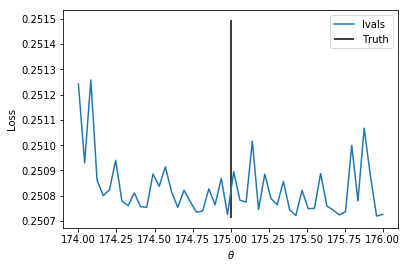

In [73]:
plt.plot(thetas,lvals_plot, label = "lvals")
plt.vlines(175, ymin = np.min(lvals), ymax = np.max(lvals), label = 'Truth')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.legend()
plt.show()